In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 1500)

from copy import deepcopy
from collections import defaultdict

import camels
from camels import Game, State

# Probability stats

In [2]:
def amplitude_sampler(init_state):
    def sample_one():
        game = Game(init_state=init_state)
        game.finish_round()
        return game.board.state.leaderboard()
    return sample_one

In [5]:
def amplitude_stats(num, init_state):
    sample_one = amplitude_sampler(init_state)
    camel_order = init_state.leaderboard()
    res = {camel: np.zeros(len(camel_order), dtype=np.float64) for camel in camel_order}
    for _ in range(num):
        sample = sample_one()
        for i, camel in enumerate(sample):
            res[camel][i] += 1
    for v in res.values():
        v /= num
    return res

In [6]:
amplitude_stats(10000, init_state=State.from_dict({1: ["a5"], 3: ["a2", "a1", "a0"]}))

{'a5': array([0.7212, 0.1055, 0.0725, 0.1008]),
 'a2': array([0.1111, 0.4841, 0.251 , 0.1538]),
 'a1': array([0.0969, 0.2241, 0.3807, 0.2983]),
 'a0': array([0.0708, 0.1863, 0.2958, 0.4471])}

# Topology analysis

In [22]:
def extract_topologies(state, die_state):
    groups = group_positions(state, die_state)
    return set([hash_group(group, state, die_state) for group in groups])
        
def group_positions(state, die_state):
    ordered = sorted(list(state))
    groups = []
    group = []
    for i in ordered:
        camels_here = state[i]
        realsize = len(set(camels_here.camels) - set(die_state))
        if realsize == 0:
            continue
        if group and i - group[-1] > 3:
            groups.append(group)
            group = []
        group.append(i)
    if group:
        groups.append(group)
    return groups

def hash_group(group, state, die_state):
    res = []
    min_pos = group[0]
    max_pos = group[-1]
    for pos in range(min_pos, max_pos+1):
        stack = state.get(pos)
        size = len(set(stack.camels) - set(die_state)) if stack else 0
        res.append(size)
    return ",".join(map(str, res))

In [23]:
def sampler(camels):
    def sample_one():
        game = Game(camels=camels)
        topologies = defaultdict(int)
        num_rounds = 0
        while max(game.board.state.pos_to_stack) < 16:
            game.one_step()
            cur_tops = extract_topologies(game.board.state.pos_to_stack, game.die.state)
            for top in cur_tops:
                topologies[top] += 1
            num_rounds += 1
        return {k: v/num_rounds for  k, v in topologies.items()}
    return sample_one

In [30]:
def stats(num, camels):
    sample_one = sampler(camels)
    topologies = defaultdict(int)
    for _ in range(num):
        sample = sample_one()
        for top, count in sample.items():
            topologies[top] += count
    res = []
    for camel_hash, freq in topologies.items():
        part = {"nums": freq}
        part.update(process_hash(camel_hash))
        res.append(pd.DataFrame(part, index=[camel_hash]))
    res = pd.concat(res)
    res["nums"] /= num
    return res.sort_values("nums", ascending=False)

In [31]:
res = stats(10000, ["a5", "a4", "a3", "a2", "a1"])
display(res)

,nums,a1_1,a2_2,a2_1,a1_2,a3_2,a3_1,a4_2,a4_1,a5_2,a5_1
1,0.334953,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.078449,0.6729,0.6729,0.3271,0.3271,NaN,NaN,NaN,NaN,NaN,NaN
"1,1",0.067538,0.6125,0.6125,0.3875,0.3875,NaN,NaN,NaN,NaN,NaN,NaN
"1,0,1",0.051854,0.7751,0.7751,0.2249,0.2249,NaN,NaN,NaN,NaN,NaN,NaN
"1,0,0,1",0.035395,0.8305,0.8305,0.1695,0.1695,NaN,NaN,NaN,NaN,NaN,NaN
3,0.023617,0.5039,0.4001,0.3262,0.2956,0.3043,0.1699,NaN,NaN,NaN,NaN
"1,2",0.022733,0.5330,0.4628,0.2645,0.2734,0.2638,0.2025,NaN,NaN,NaN,NaN
"2,1",0.020763,0.2983,0.2544,0.4938,0.4289,0.3167,0.2079,NaN,NaN,NaN,NaN
"1,1,1",0.018605,0.4941,0.3786,0.3014,0.3385,0.2829,0.2045,NaN,NaN,NaN,NaN
"1,0,2",0.016860,0.5760,0.5703,0.2862,0.3125,0.1172,0.1378,NaN,NaN,NaN,NaN


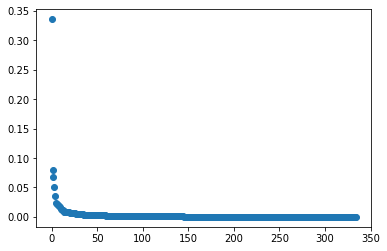

In [42]:
plt.scatter([i for i in range(len(res["nums"]))], res["nums"])

In [26]:
def process_hash(camel_hash):
    counts = {i: int(v) for i,v in enumerate(camel_hash.split(",")) if v != 0}
    total = sum(counts.values())
    pos_to_camels = {}
    cnt = total
    for pos, count in counts.items():
        camels = []
        for _ in range(count):
            camels.append(f"a{cnt}")
            cnt -= 1
        pos_to_camels[pos] = camels
    state = State.from_dict(pos_to_camels)
    camel_order = state.leaderboard()
    amplitude = amplitude_stats(10000, init_state=state)
    res = {}
    for k, v in amplitude.items():
        if len(v) > 1:
            res[f"{k}_2"] = v[-2]
        res[f"{k}_1"] = v[-1]
    return res

In [16]:
process_hash("3,0,1")

{'a4_2': 0.1601,
 'a4_1': 0.1002,
 'a3_2': 0.2629,
 'a3_1': 0.2389,
 'a2_2': 0.2341,
 'a2_1': 0.3797,
 'a1_2': 0.3429,
 'a1_1': 0.2812}

In [35]:
res[['nums', 'a1_1', 'a1_2', 'a2_1', 'a2_2', 'a3_1', 'a3_2', 'a4_1', 'a4_2', 'a5_1', 'a5_2']].to_csv("amplitudes_byfreq.tsv", sep="\t", index_label="comb")

In [37]:
res[['nums', 'a1_1', 'a1_2', 'a2_1', 'a2_2', 'a3_1', 'a3_2', 'a4_1', 'a4_2', 'a5_1', 'a5_2']].sort_index()#.to_csv("amplitudes_byname.tsv", sep="\t", index_label="comb")

,nums,a1_1,a1_2,a2_1,a2_2,a3_1,a3_2,a4_1,a4_2,a5_1,a5_2
1,0.334953,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"1,0,0,1",0.035395,0.8305,0.1695,0.1695,0.8305,NaN,NaN,NaN,NaN,NaN,NaN
"1,0,0,1,0,0,1",0.002906,0.8330,0.1496,0.1496,0.6971,0.0174,0.1533,NaN,NaN,NaN,NaN
"1,0,0,1,0,0,1,0,0,1",0.000146,0.8347,0.1448,0.1448,0.7049,0.0188,0.1321,0.0017,0.0182,NaN,NaN
"1,0,0,1,0,0,1,0,0,1,0,0,1",0.000007,0.8330,0.1498,0.1498,0.6986,0.0154,0.1334,0.0018,0.0159,0.0000,0.0023
"1,0,0,1,0,0,1,0,0,2",0.000097,0.5849,0.3352,0.3030,0.5968,0.1008,0.0611,0.0108,0.0063,0.0005,0.0006
"1,0,0,1,0,0,1,0,1",0.000210,0.7854,0.1830,0.1830,0.6784,0.0290,0.1224,0.0026,0.0162,NaN,NaN
"1,0,0,1,0,0,1,0,1,0,0,1",0.000032,0.8413,0.1409,0.1409,0.6553,0.0165,0.1752,0.0012,0.0257,0.0001,0.0029
"1,0,0,1,0,0,1,0,1,0,1",0.000011,0.7793,0.1879,0.1879,0.6161,0.0296,0.1663,0.0028,0.0262,0.0004,0.0035
"1,0,0,1,0,0,1,0,1,1",0.000021,0.5052,0.3516,0.3120,0.4544,0.1634,0.1701,0.0177,0.0219,0.0017,0.0020
